In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const, units as u

import growpacity as op

from scipy.interpolate import interpn

In [2]:
# provide optool optional arguments (eg. composition)
# optool_args = '-p 0.5' # for example
optool_args = '' # default
OC = op.OpacityCalculator(amax_min=0.1*u.um, amax_max=1*u.um, Namax=3, # 2 bins per decade
                           T_min=1*u.K, T_max=3000*u.K, NT=101, # good enough
                           q_min=-4.5, q_max=-2.5, Nq=9, # every 0.25 -> resolves exactly for -3, -3.75, -3.5
                           optool_args=optool_args, dirc='data/')

In [3]:
# if you want to just use the default dataset, first unzip default-data.tar.gz and then run this (without changes!)
OC = op.OpacityCalculator(amax_min=0.1*u.um, amax_max=1*u.m, Namax=15, # 2 bins per decade
                           T_min=1*u.K, T_max=3000*u.K, NT=101, # good enough
                           q_min=-4.5, q_max=-2.5, Nq=9, # every 0.25 -> resolves exactly for -3, -3.75, -3.5
                           optool_args='', dirc='default-data/')

In [4]:
# call optool to compute the opacities for each a_max and q and store them in separate files.
# larger a_max takes longer, and for this dataset the largest grain size is 1 um.
# So this will take a while. Maybe run it overnight. But you will already have practically enough data
# to compute opacities up to ~1cm within an hour.

# If you're using the default dataset, this should finish immediately!
# If in that case you still see output, something is wrong.
OC.execute_optool(quiet=True)

In [5]:
# The class now can read all that optool output. Use it to compute Rosseland and Planck means.
# The Rosseland mean includes scattering with the Henyey & Greenstein (1941) approach (g factor).
# Files are output in the same folder as the frequency-dependent opacity data.
OC.build_mean_opacities(overwrite=True)

/Users/ziampras/base/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in square
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [6]:
# now load it all from the disk into 3D arrays of q, a_max, T and then store the 3D arrays
OC.compute_and_store_master_arrays(overwrite=True)

In [7]:
# now load that 3D data
kR_arr, kP_arr = OC.load_master_arrays()

In [8]:
q    = OC.q
amax = OC.amax.to_value('um')
T    = OC.T.to_value('K')
arrs = (q, amax, T)

def where(arr, v): return np.argmin(np.abs(arr-v))

# make sure the interpolation arrays include the raw datapoints to properly compare later
def combined(arr1, arr2): return np.unique(np.sort(np.concatenate((arr1, arr2))))

In [9]:
a_interp = combined(np.geomspace(amax.min(), amax.max(), 120), amax)
T_interp = combined(np.geomspace(T.min(), T.max(), 2000), T)
q_interp = q[where(q, -3.75)]

values = np.meshgrid(q_interp, np.log10(a_interp), np.log10(T_interp), indexing='ij')
points = np.array([values[i].flatten() for i in range(len(values))]).T

kR_interp = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kR_arr), \
              points, bounds_error=True, method='linear').reshape(a_interp.size, T_interp.size)

kP_interp = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kP_arr), \
              points, bounds_error=True, method='linear').reshape(a_interp.size, T_interp.size)

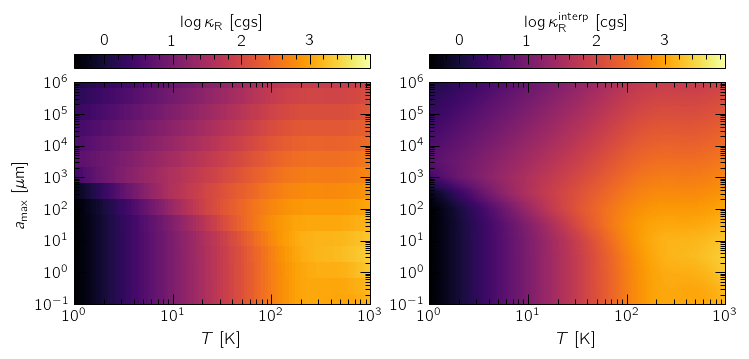

In [10]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx  = where(q, q_interp)

qty = np.log10(kR_arr[idx])
plotargs = dict(vmin=qty.min(), vmax=qty.max(), cmap=plt.cm.inferno)
img0 = ax[0].pcolormesh(T, amax, qty, **plotargs)
img1 = ax[1].pcolormesh(T_interp, a_interp, np.log10(kR_interp), **plotargs)

for axis in ax:
    axis.loglog()
    axis.set_ylim(0.1, 1e6)
    axis.set_xlim(1, 1000)
    axis.set_xlabel(r'$T$ [K]')

ax[0].set_ylabel(r'$a_\text{max}$ [$\mu$m]')

plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')

plt.show()

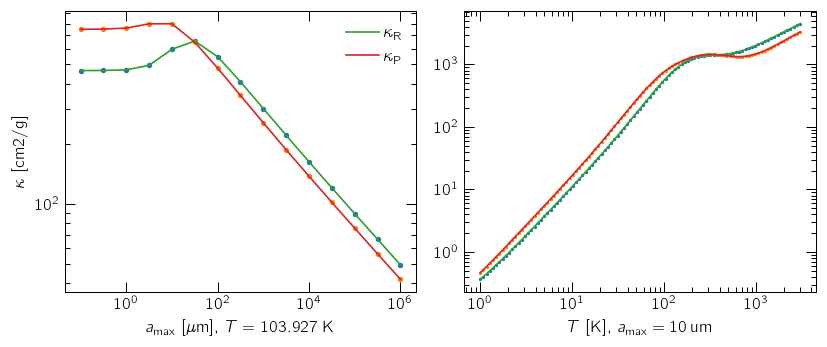

In [11]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(q, q_interp)
T_  = T[where(T, 100)]
amax_ = amax[where(amax, 10)]

ax[0].scatter(amax, kR_arr[idx, :, where(T, T_)], s=5, c='C0')
ax[0].plot(a_interp, kR_interp[:, where(T_interp, T_)], label=r'$\kappa_\text{R}$', c='C2')
ax[0].scatter(amax, kP_arr[idx, :, where(T, T_)], s=5, c='C1')
ax[0].plot(a_interp, kP_interp[:, where(T_interp, T_)], label=r'$\kappa_\text{P}$', c='C3')

ax[1].scatter(T, kR_arr[idx, where(amax, amax_), :], s=1, c='C0')
ax[1].plot(T_interp, kR_interp[where(a_interp, amax_)], c='C2')

ax[1].scatter(T, kP_arr[idx, where(amax, amax_), :], s=1, c='C1')
ax[1].plot(T_interp, kP_interp[where(a_interp, amax_)], c='C3')

for axis in ax: axis.set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend()

ax[0].set_ylabel(r'$\kappa$ [cm2/g]')
ax[0].set_xlabel(r'$a_\text{max}$ [$\mu$m], $T=%g$ K'%T_)
ax[1].set_xlabel(r'$T$ [K], $a_\text{max} = %g$\,um'%amax_)

fig.tight_layout()

plt.show()

In [12]:
a_interp = amax[where(amax, 1e3)]
T_interp = combined(np.geomspace(T.min(), T.max(), 2000), T)
q_interp = combined(np.linspace(q.min(), q.max(), 100), q)

values = np.meshgrid(q_interp, np.log10(a_interp), np.log10(T_interp), indexing='ij')
points = np.array([values[i].flatten() for i in range(len(values))]).T

kR_interp = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kR_arr), \
              points, bounds_error=True, method='linear').reshape(q_interp.size, T_interp.size)

kP_interp = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kP_arr), \
              points, bounds_error=True, method='linear').reshape(q_interp.size, T_interp.size)

/var/folders/kw/3czc6kbs3jj04cd5vr2g9v1w0000gn/T/ipykernel_7579/2557423934.py:17: UserWarning: Adding colorbar to a different Figure <Figure size 840x360 with 4 Axes> than <Figure size 840x360 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
/var/folders/kw/3czc6kbs3jj04cd5vr2g9v1w0000gn/T/ipykernel_7579/2557423934.py:18: UserWarning: Adding colorbar to a different Figure <Figure size 840x360 with 4 Axes> than <Figure size 840x360 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')


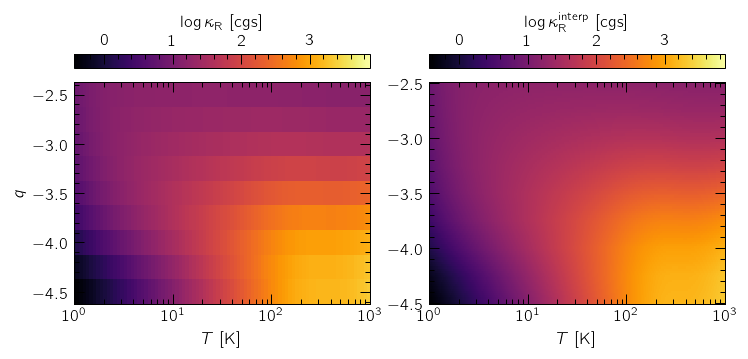

In [13]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(amax, a_interp)

qty = np.log10(kR_arr[:,idx])
plotargs = dict(vmin=qty.min(), vmax=qty.max(), cmap=plt.cm.inferno)
ax[0].pcolormesh(T, q, qty, **plotargs)
ax[1].pcolormesh(T_interp, q_interp, np.log10(kR_interp), **plotargs)

for axis in ax:
    axis.set_xscale('log')
    axis.set_xlim(1, 1000)
    axis.set_xlabel(r'$T$ [K]')

ax[0].set_ylabel(r'$q$')

plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')

plt.show()

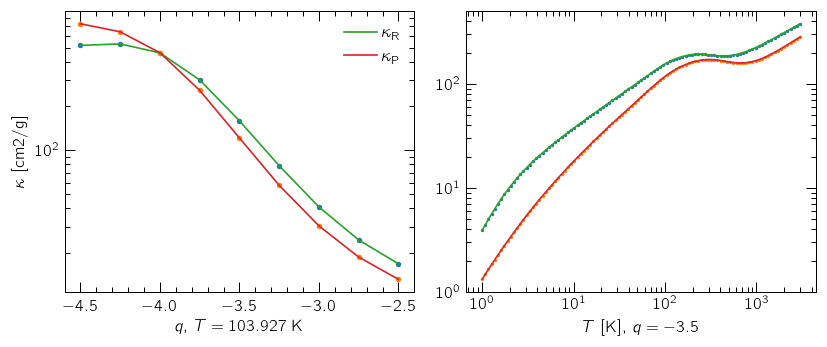

In [14]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(amax, a_interp)
T_  = T[where(T, 100)]
q_  = q[where(q, -3.5)]

ax[0].scatter(q, kR_arr[:, idx, where(T, T_)], s=5, c='C0')
ax[0].plot(q_interp, kR_interp[:, where(T_interp, T_)], label=r'$\kappa_\text{R}$', c='C2')
ax[0].scatter(q, kP_arr[:, idx, where(T, T_)], s=5, c='C1')
ax[0].plot(q_interp, kP_interp[:, where(T_interp, T_)], label=r'$\kappa_\text{P}$', c='C3')

ax[1].scatter(T, kR_arr[where(q, q_), idx], s=1, c='C0')
ax[1].plot(T_interp, kR_interp[where(q_interp, q_)], c='C2')
ax[1].scatter(T, kP_arr[where(q, q_), idx], s=1, c='C1')
ax[1].plot(T_interp, kP_interp[where(q_interp, q_)], c='C3')

for axis in ax: axis.set_yscale('log')
ax[1].set_xscale('log')
ax[0].legend()

ax[0].set_ylabel(r'$\kappa$ [cm2/g]')
ax[0].set_xlabel(r'$q$, $T=%g$ K'%T_)
ax[1].set_xlabel(r'$T$ [K], $q=%g$'%q_)

fig.tight_layout()

plt.show()

In [15]:
a_interp = combined(np.geomspace(amax.min(), amax.max(), 120), amax)
T_interp = T[where(T, 1000)]
q_interp = combined(np.linspace(q.min(), q.max(), 100), q)

values = np.meshgrid(q_interp, np.log10(a_interp), np.log10(T_interp), indexing='ij')
points = np.array([values[i].flatten() for i in range(len(values))]).T

kR_interp = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kR_arr), \
              points, bounds_error=True, method='linear').reshape(q_interp.size, a_interp.size)

kP_interp = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kP_arr), \
              points, bounds_error=True, method='linear').reshape(q_interp.size, a_interp.size)

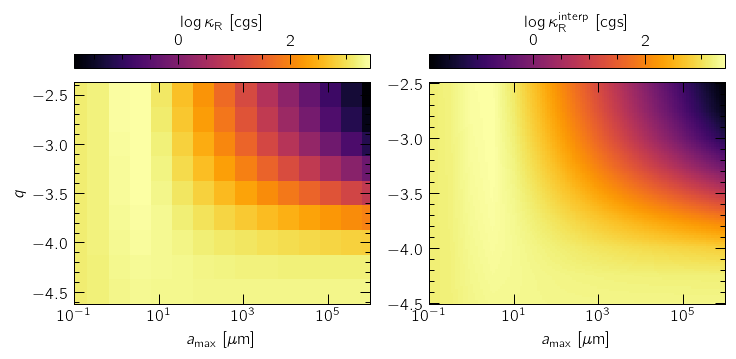

In [16]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(T, T_interp)

qty = np.log10(kR_arr[:,:,idx])
plotargs = dict(vmin=qty.min(), vmax=qty.max(), cmap=plt.cm.inferno)
img0 = ax[0].pcolormesh(amax, q, np.log10(kR_arr[:,:,idx]), **plotargs)
img1 = ax[1].pcolormesh(a_interp, q_interp, np.log10(kR_interp), **plotargs)

for axis in ax:
    axis.set_xscale('log')
    axis.set_xlim(0.1, 1e6)
    axis.set_xlabel(r'$a_\mathrm{max}$ [$\mu$m]')

ax[0].set_ylabel(r'$q$')

plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')

plt.show()

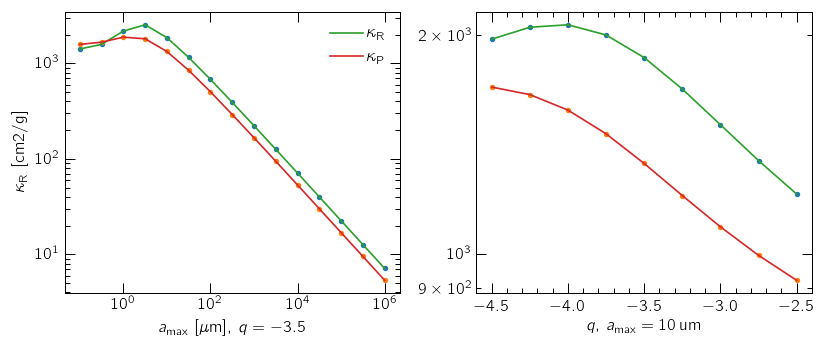

In [17]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(T, T_interp)
q_  = q[where(q, -3.5)]
amax_ = amax[where(amax, 10)]

ax[0].scatter(amax, kR_arr[where(q, q_), :, idx], s=5, c='C0')
ax[0].plot(a_interp, kR_interp[where(q_interp, q_), :], label=r'$\kappa_\text{R}$', c='C2')
ax[0].scatter(amax, kP_arr[where(q, q_), :, idx], s=5, c='C1')
ax[0].plot(a_interp, kP_interp[where(q_interp, q_), :], label=r'$\kappa_\text{P}$', c='C3')

ax[1].scatter(q, kR_arr[:, where(amax, amax_), idx], s=5, c='C0')
ax[1].plot(q_interp, kR_interp[:,where(a_interp, amax_)], c='C2')
ax[1].scatter(q, kP_arr[:, where(amax, amax_), idx], s=5, c='C1')
ax[1].plot(q_interp, kP_interp[:,where(a_interp, amax_)], c='C3')

for axis in ax: axis.set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()

ax[0].set_ylabel(r'$\kappa_\text{R}$ [cm2/g]')
ax[0].set_xlabel(r'$a_\text{max}$ [$\mu$m], $q=%g$'%q_)
ax[1].set_xlabel(r'$q$, $a_\text{max} = %g$\,um'%amax_)

fig.tight_layout()

plt.show()

In [23]:
# check interpolator against scipy
qtest, atest, Ttest = -2.65, 0.4e4, 120 # amax in um, T in K
def have(arr, x): return np.isclose(arr[where(arr, x)], x)
if have(q, qtest): print('Warning: this value of qtest already exists!')
if have(amax, atest): print('Warning: this value of atest already exists!')
if have(T, Ttest): print('Warning: this value of Ttest already exists!')

# note that evaluate_mean_opacity expects amax in cm
ev1 = op.evaluate_mean_opacity(*arrs, kR_arr, qtest, atest/1e4, Ttest)

ev2 = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kR_arr),
              (qtest, np.log10(atest), np.log10(Ttest)), bounds_error=True)[0]

print("Rosseland:")
print(f'Computed:   {ev1:.16e}')
print(f'Scipy:      {ev2:.16e}')
print(f'Difference: {ev1/ev2-1:.16e}')

# note that evaluate_mean_opacity expects amax in cm
ev1 = op.evaluate_mean_opacity(*arrs, kP_arr, qtest, atest/1e4, Ttest)

ev2 = 10 ** interpn((q, np.log10(amax), np.log10(T)), np.log10(kP_arr),
              (qtest, np.log10(atest), np.log10(Ttest)), bounds_error=True)[0]

print("Planck:")
print(f'Computed:   {ev1:.16e}')
print(f'Scipy:      {ev2:.16e}')
print(f'Difference: {ev1/ev2-1:.16e}')

Rosseland:
Computed:   5.1912301767431090e+00
Scipy:      5.1912301767431090e+00
Difference: 0.0000000000000000e+00
Planck:
Computed:   4.1026218997239514e+00
Scipy:      4.1026218997239523e+00
Difference: -2.2204460492503131e-16


In [18]:
# test speed
%timeit op.evaluate_mean_opacity(*arrs, kP_arr, qtest, atest, Ttest) # 776 ns ± 10.8 on my laptop

776 ns ± 10.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [19]:
# scipy: note that here we're taking the log of everything
# before entering the function (so it can be much faster!)
# We're still a factor 70 faster though
arrs_ = (q, np.log10(amax), np.log10(T))
point_ = (qtest, np.log10(atest), np.log10(Ttest))
logkP = np.log10(kP_arr)
%timeit np.pow(interpn(arrs_, logkP, point_, bounds_error=False)[0], 10) # 56.2 μs ± 870 ns on my laptop

56.2 μs ± 870 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
kP_arr[]

array([[[4.62625800e-01, 5.18748099e-01, 5.82890881e-01, ...,
         4.95555795e+03, 5.59405148e+03, 6.31739202e+03],
        [4.62625958e-01, 5.18748306e-01, 5.82891153e-01, ...,
         5.37683200e+03, 6.03140397e+03, 6.75366665e+03],
        [4.62626693e-01, 5.18749267e-01, 5.82892413e-01, ...,
         5.28304986e+03, 5.84512665e+03, 6.45505224e+03],
        ...,
        [4.82849664e-01, 5.41873840e-01, 6.09383457e-01, ...,
         4.16703820e+03, 4.57381151e+03, 5.01395041e+03],
        [4.82660118e-01, 5.41659713e-01, 6.09141225e-01, ...,
         4.16549438e+03, 4.57214676e+03, 5.01216122e+03],
        [4.82555379e-01, 5.41542166e-01, 6.09009018e-01, ...,
         4.16439864e+03, 4.57091430e+03, 5.01077443e+03]],

       [[4.62625800e-01, 5.18748099e-01, 5.82890881e-01, ...,
         4.95555795e+03, 5.59405148e+03, 6.31739202e+03],
        [4.62625963e-01, 5.18748313e-01, 5.82891162e-01, ...,
         5.40390236e+03, 6.05720427e+03, 6.77648698e+03],
        [4.62626906e-01, 

In [35]:
kP_arr[7][10][60]

np.float64(1.9609143035329017)